<a href="https://www.kaggle.com/code/bisheshchakraborty/titanic-xgboost-with-grid-search?scriptVersionId=145397968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
%config Completer.use_jedi = False

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
# Import the datasets
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

### Exploratory Data Analysis

<Axes: ylabel='Frequency'>

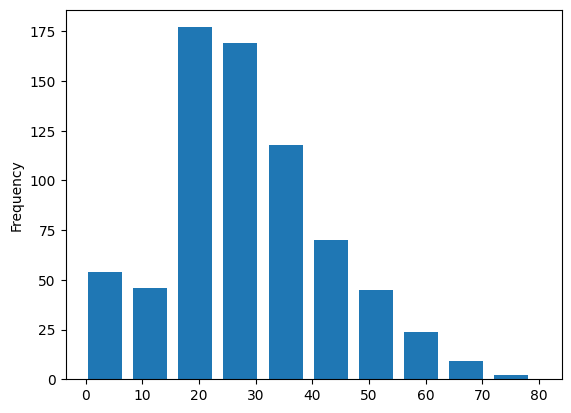

In [18]:
train_data['Age'].sort_values(ascending=False).plot(kind = 'hist', width=6)

In [ ]:
# Check data types of variables
train_data.info()

In [ ]:
# View top 5 data
train_data.head()

In [ ]:
# Check basic statistical summary of numeric columns
train_data.describe(include='number')

In [ ]:
train_data.describe(exclude='number')

### Extracting Titles from Names column

In [ ]:
train_titles = train_data['Name'].str.split().str[1].str.replace('.', '').str.strip()

In [ ]:
train_data['Title'] = train_data['Name'].str.extract('([A-Za-z]+\.)', expand=False).str.replace('.', '')
test_data['Title'] = test_data['Name'].str.extract('([A-Za-z]+\.)', expand=False).str.replace('.', '')

In [ ]:
train_data.Title.value_counts(normalize=True)

In [ ]:
test_data['Title'].unique()

In [ ]:
test_data[test_data['Title'] == 'Dona']

### Mapping Titles to categories as follows :

- Mr, Mrs, Miss, Master, Mlle, Mme, Ms : Civilian (0)
- Lady, Sir, Don, Dona, Countess, Jonkheer : Nobility (1)
- Major, Col, Capt : Military (2)
- Rev, Dr : Professional (3)

>*Note :  There's a Title of 'Dona' in test dataset. Can be added to title mappings here or imputed later.<br>
          Turns out that 'Dona' is the feminine form of 'Don' in Spain/Portugal/Italy.*
        

In [ ]:
title_mappings = {
    'Mr': 0, 'Mrs': 0, 'Miss': 0, 'Master': 0, 'Mlle': 0, 'Mme': 0, 'Ms': 0,
    'Lady': 1, 'Sir': 1, 'Don': 1, 'Dona': 1, 'Countess': 1, 'Jonkheer': 1,
    'Major': 2, 'Col': 2, 'Capt': 2,
    'Rev': 3, 'Dr': 3
}

In [ ]:
train_data['Title'] = train_data.Title.map(title_mappings)
test_data['Title'] = test_data.Title.map(title_mappings)

### Drop irrelevant columns

In [ ]:
# Drop 'Name' and 'Cabin' columns
train_data = train_data.drop(columns=['Name','Cabin','Ticket'])
test_data = test_data.drop(columns=['Name','Cabin','Ticket'])

### Check for duplicate rows

In [ ]:
# Check for duplicate rows
train_data[train_data.duplicated()]
test_data[test_data.duplicated()]

### Impute missing values

In [ ]:
# Check count of 'NaN' values in columns
train_data.isna().sum()

In [ ]:
# Check the categorical data in 'Embarked' column
train_data['Embarked'].value_counts(dropna=False)

In [ ]:
# Check the NaN rows
train_data[train_data['Embarked'].isna()]

In [ ]:
train_data['Embarked'].mode()[0]

In [ ]:
# Either drop these rows or impute with most frequent category
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [ ]:
# Check mean and median of 'Age'
train_data['Age'].mean(), train_data['Age'].median()

In [ ]:
# Impute missing values of 'Age' column with mean/median
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

In [ ]:
# Test data has a missing value in 'Fare' column
test_data[test_data['Fare'].isna()]

In [ ]:
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [ ]:
# Test data has a missing value in 'Title' column
test_data[test_data['Title'].isna()]

In [ ]:
# test_data['Title'].fillna(test_data['Title'].mode()[0], inplace=True)

### Create dummies for categorical variables

In [ ]:
train_data.dtypes

In [ ]:
# Create dummies for categorical variables dropping the first
train_data = pd.get_dummies(data=train_data, columns=['Pclass','Sex','Embarked'], drop_first=True)
test_data = pd.get_dummies(data=test_data, columns=['Pclass','Sex','Embarked'], drop_first=True)

### Build Model

In [ ]:
X_train = train_data.drop(columns=['Survived'])
X_test = test_data
y_train = train_data['Survived']

In [ ]:
sns.heatmap(pd.concat([X_train, train_data['Survived']], axis=1).corr(), cmap='Blues')

In [ ]:
# logreg = LogisticRegression(max_iter=3000)
# logreg.fit(X_train, y_train)
# Y_pred_logreg = logreg.predict(X_train)

# acc_logreg_train = accuracy_score(y_train, Y_pred_logreg)
# acc_logreg_train

# predictions = logreg.predict(X_test)

In [ ]:
# grid = {
#     'n_estimators': [100, 200, 400, 500, 800],
#     'max_depth': [3, 4, 5, 7, 8, 12, 14]
# }

# rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid = grid, scoring='accuracy', n_jobs=4, cv=5)
# rf_cv.fit(X_train, y_train)
# rf_cv.best_params_
# rf_cv_final = rf_cv.best_estimator_
# rf_cv_pred = rf_cv_final.predict(X_test)

### Cross Validation with Grid Search

In [ ]:
grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [ ]:
xgb_cv = GridSearchCV(estimator=XGBClassifier(), param_grid = grid, scoring='accuracy', n_jobs=4, cv=5)

In [ ]:
xgb_cv.fit(X_train, y_train)

In [ ]:
xgb_cv.best_params_

In [ ]:
xgb_cv_final = xgb_cv.best_estimator_
xgb_cv_pred = xgb_cv_final.predict(X_test)

In [ ]:
output = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived': xgb_cv_pred})
output.to_csv('/kaggle/working/submission.csv', index=False)